## Generate Power-Grid data 
Step 1: Sample random points within city boundaries and export the node data (id, type, lat, long).

<Axes: >

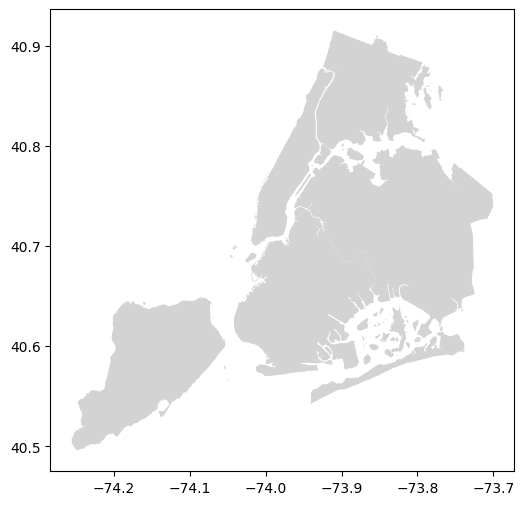

In [46]:
## Import shapefile and plot
import geopandas as gp
import matplotlib.pyplot as plt
nyc_limits = gp.read_file("nyc_shapefiles/geo_export_63f58815-fd23-40a8-8d30-fd6212e5e404.shp")
fig, ax = plt.subplots(figsize = (6,6))
nyc_limits.plot(ax=ax, color='lightgrey')

<Axes: >

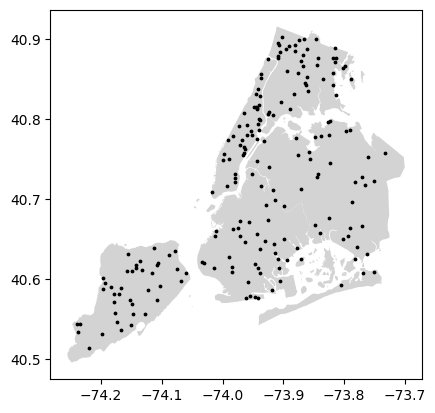

In [48]:
## Sample substations points
num_substations = [40,40,40,40,40]
substations = nyc_limits.sample_points(num_substations)

## Plot points on map
ax = substations.plot(color="k",zorder=2,markersize=3)
nyc_limits.to_crs(epsg=4326).plot(ax=ax, color='lightgrey',zorder=1)

In [49]:
## Clean up and export data
substations_xy = substations.explode(ignore_index=True).get_coordinates()
substation_tbl = substations_xy.rename(columns = {'x':'long', 'y':'lat'})
substation_tbl['node_id'] = substation_tbl.index
substation_tbl['type'] = "power"

substation_tbl = substation_tbl[['node_id','type','lat','long']]
substation_tbl

substation_tbl.to_csv("generated_nodes.csv")

Step 2: Connect nodes based on some algorithm to form a network (closer nodes more likely to be connected), and export the adjacency matrix.

In [61]:
from libpysal import weights, examples
import networkx as nx
import numpy as np

coordinates = np.column_stack((substations_xy['x'], substations_xy['y']))
dist = weights.Relative_Neighborhood(coordinates)
dist_graph = dist.to_networkx()

adj_matrix = nx.to_pandas_adjacency(dist_graph)
adj_matrix.to_csv("generated_adjmat.csv",index=False)

/tmp/ipykernel_1200535/1663611145.py:6: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  dist = weights.Relative_Neighborhood(coordinates)


Step 3: Create a visualization of network and export plot.

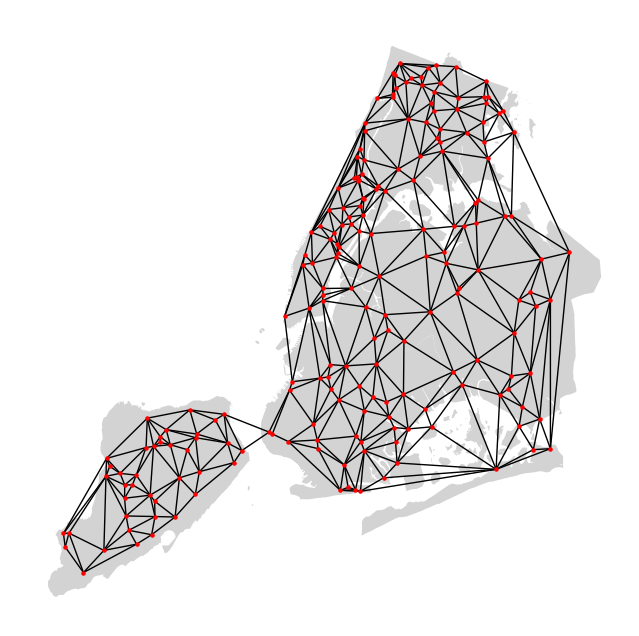

In [53]:
positions = dict(zip(dist_graph.nodes, coordinates))

f, ax = plt.subplots(figsize=(8, 8))
nx.draw(dist_graph, positions, ax=ax, node_size=5, node_color="r")
nyc_limits.to_crs(epsg=4326).plot(ax=ax, color='lightgrey',zorder=0)
plt.show()
f.savefig("generated_network.pdf")


Step 4: Verify stored data

In [83]:
## Verify data integrity by reimporting and plotting the network

import pandas as pd
saved_adjmat = np.genfromtxt('generated_adjmat.csv', delimiter=',')
saved_adjmat = saved_adjmat[1:,]

saved_positions = pd.read_csv("generated_nodes.csv")
pos = np.column_stack((saved_positions['long'],saved_positions['lat']))


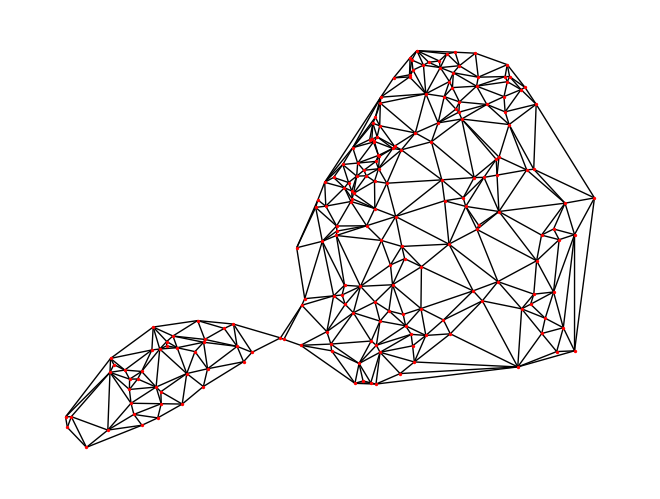

In [82]:
rows, cols = np.where(saved_adjmat == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, pos=pos, node_size=2,node_color="r")
plt.show()